# Stream sim galpy

This notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential (commonly the milky way MW).
It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

# Initialization

Import useful libraries and utilities, cluster_config file

In [385]:
###Libraries
#Mains
%matplotlib widget
# %matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities

<module 'stream_galsim.stream_utils' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/stream_utils.py'>

In [386]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)
# print(stream_data)
#only progenitor data is wanted for our simulation
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
#["dec","dec_unit","distance","distance_unit","frame","pm_dec","pm_dec_unit","pm_ra_cosdec","pm_ra_cosdec_unit", "ra","ra_unit","radial_velocity","radial_velocity_unit"]
print(progenitor.values.tolist()[0])

['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]



# Data generation with stellar stream simulation

The first objective is to generate stellar flux data using a simulation.
The user must choose between a mock flux simulation and an N-body flux simulation.

The mock flux simulation uses the particle spray technique with galpy/gala: it generates n stars outside the progenitor at each time step dt, initially requiring only the progenitor's orbit as input in phase space. It is faster, but provides a simplified model of the flux, providing only the main stars.

The N-body simulation simulates the complete development of the flux, treating each star as a massless body initially within the progenitor, and decaying it under tidal effects.

"Mock" stream using galpy library.

**Step 1: System initialisation.**

The system includes initially a progenitor, an accreting host, a perturbating DM subhalo (optional), and a cluster host like dwarf galaxies (optional)

In [387]:
###Progenitor
#progenitor coord 
cluster = progenitor.values.tolist()[0][0]
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS


prog_mass = 2*10.**4.*u.Msun
prog_a = 23.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
# prog_sigv = sutils.Plummer_sigv(prog_mass, prog_a, rc)
prog_sigv = 0.365*u.km/u.s #velocity dispersion in original cluster. It's assumed that the velocity distribution is isotropic
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
#mw_pot = gp.LogarithmicHaloPotential(normalize=1.,q=0.9) #is also often used


###Dark matter subhalo(s) and impact parameters
halo_mass = 1e5 *u.Msun #halo mass
halo_a =0.01*u.kpc
halo_pot = gp.NFWPotential(amp=halo_mass, a=halo_a)
v_halo = np.array([6.82200571,132.7700529,149.4174464]) #in km/s (vx,vy,vz)

b_impact = 0.#1 * u.pc
t_impact = 1* u.Gyr
angle_impact= 0.5
###DG, initially hosting the cluster. Optional

In [388]:
### Action angle setup - for action-angle space
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=1.5)

**Step 2: Stream pdf generation**

In [342]:
###Modelise Non-perturbed stream and perturbed stream using streamdf
#we use full_galpydf from sutils to get the complete pdf (trail + lead + perturbed) in a single run

s_lead, s_trail, s_perturbed = sutils.full_galpy_df(
                        sigv=prog_sigv, #Radial velocity dispersion of the progenitor
                        progenitor=prog_orbit, #Progenitor orbit instance
                        pot = mw_pot, #accreting host potential
                        aA = aaisochrone, #ActionAngle instance used to convert (x,v) to actions. Generally a actionAngleIsochroneApprox instance.                        vsun=vsun,
                        ro = R0, #Distance scale for translation into internal units
                        vo = V0, #Velocity scale for translation into internal units
                        vsun = vsun,                         
                        tdisrupt = t_disrupt,#  Time since start of disruption
                        perturbed = True,
                        timpact = t_impact, # Time of impact
                        impactb = b_impact, #Impact parameter between halo and streams
                        subhalovel = v_halo, # Velocity of the subhalo
                        subhalopot = halo_pot,# Gravitational potential of the subhalo
                        impact_angle = angle_impact, #Angle offset from progenitor at which the impact occurred
                        )

/home/hallouin/miniconda3/envs/streams/lib/python3.13/site-packages/galpy/df/streamgapdf.py:1554: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(_a_integrand, -1.0, 1.0, args=(y, b, w, pot, i))[0]



**Step 3: Sampling from stream pdf**

In [389]:
#lead, trail, lead+trail, perturbed arm, perturbed arm+other arm
np.random.seed(4)
s_lead_stars, s_trail_stars, s_full_stars, ps_stars, ps_full_stars = sutils.full_galpy_sampling(n_stars=1000, 
                                                                    s_lead=s_lead, s_trail=s_trail, s_perturbed=s_perturbed,
                                                                    ro=R0, vo=V0, perturbed = 'lead', rdseed = 4)

In [390]:
x_s, y_s ,z_s, vx_s, vy_s , vz_s = s_full_stars
x_ps, y_ps ,z_ps, vx_ps, vy_ps , vz_ps = ps_full_stars

**Step 4: conversion into observer coordinate system and plot**

In simulation as in data analysis, the main goal of the study is to compute the star density variation along the stream. Hence we need to convert star positions in an appropriate and more physical frame. We'll use icrs then (Phi1,Phi2) coordinate system, where phi1 is the angle along the stream (longitude-like) and Phi2 the angle perpendicular to the stream (latitude-like), as seen from Earth. We define (0,0) as the progenitor position in the sky.

In [391]:
s_stars_icrs = sutils.xyz_to_icrs(s_full_stars, velocities=True)
ra_s, dec_s, dist_s, pmra_s, pmdec_s, pmr_s = (s_stars_icrs.T.ra, s_stars_icrs.T.dec, s_stars_icrs.T.distance,
                             s_stars_icrs.T.pm_ra_cosdec, s_stars_icrs.T.pm_dec, s_stars_icrs.T.radial_velocity)

ps_stars_icrs = sutils.xyz_to_icrs(ps_full_stars,  velocities=True)
ra_ps, dec_ps, dist_ps, pmra_ps, pmdec_ps, pmr_ps = (ps_stars_icrs.T.ra, ps_stars_icrs.T.dec, ps_stars_icrs.T.distance,
                             ps_stars_icrs.T.pm_ra_cosdec, ps_stars_icrs.T.pm_dec, ps_stars_icrs.T.radial_velocity)
s_stars_icrs

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    [(226.57500717, -2.31629739, 22.49608796),
     (227.90374586, -1.33952354, 22.79982096),
     (223.1550946 , -5.90368516, 21.4211549 ), ...,
     (231.34396725,  1.82489049, 23.77147162),
     (229.14700834,  0.27712786, 23.48164151),
     (239.633809  ,  6.13157118, 24.13749116)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-228.3480798 , -210.64203513, -1.61039100e+04),
     (-230.07550664, -197.76739852, -1.40538316e+04),
     (-225.9838985 , -254.99893233, -2.16247530e+04), ...,
     (  -1.469524  ,   -1.59939384, -3.00584154e+01),
     (  -1.49476445,   -1.62632986, -1.88953402e+01),
     (  -1.40225794,   -1.52830915, -6.67211261e+01)]>

Text(0, 0.5, 'Y')

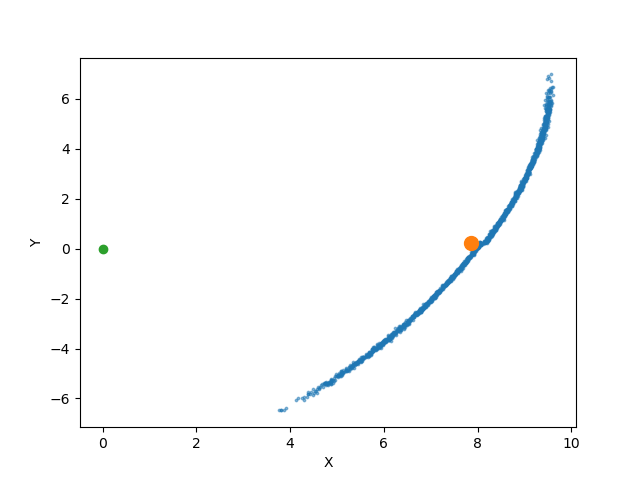

In [392]:
#3D representation
#Cluster, local background potential
c = ac.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)
fig2 = plt.figure()
ax2 = fig2.add_subplot()

ax2.scatter(-x_s, y_s, alpha=0.5, s=3)#sts
ax2.scatter(c_gc.cartesian.x,c_gc.cartesian.y,s=100)#progenitor
ax2.scatter(0,0)#galatic center

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
# ax2.set_zlabel('Z')

-2.296


Text(0.5, 0, 'Z')

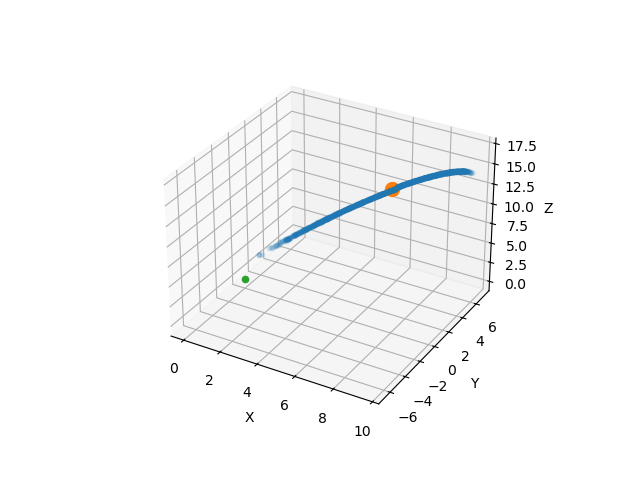

In [393]:
#3D representation
#Cluster, local background potential
c = ac.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)
print(c.pm_ra_cosdec.to_value(u.mas/u.yr))
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(-x_s, y_s ,z_s, alpha=0.1,s=10)#sts
ax3.scatter(c_gc.cartesian.x,c_gc.cartesian.y, c_gc.cartesian.z,s=100)#progenitor
ax3.scatter(0,0,0)#galatic center

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

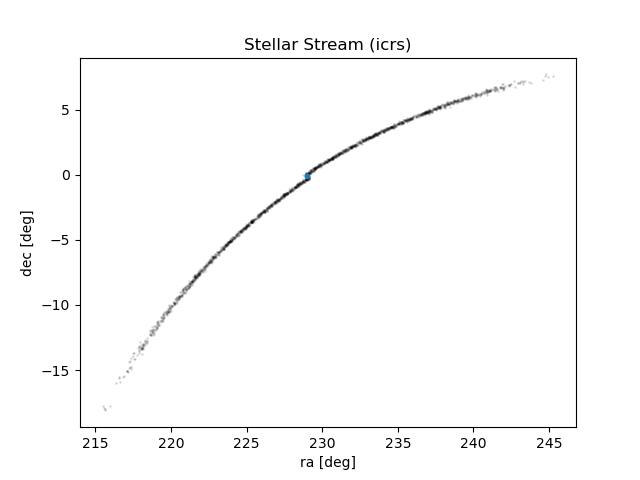

In [394]:
### plot the track in the radec frame to see how it would appears from an observer on earth
ra_prog, dec_prog = progenitor.loc[:,['ra']].values.tolist()[0], progenitor.loc[:,['dec']].values.tolist()[0]
# ra_prog, dec_prog = radec_prog
plt.figure()
# plt.scatter(ra_ps, dec_ps, s=0.5, c='purple')
plt.scatter(ra_s, dec_s, s=1, c='k', alpha=0.1)
plt.scatter(ra_prog, dec_prog, s=10)#progenitor

plt.xlabel("ra [deg]")
plt.ylabel("dec [deg]")
plt.title("Stellar Stream (icrs)")
plt.show()

In [395]:
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities

<module 'stream_galsim.stream_utils' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/stream_utils.py'>

In [396]:
### finally convert into Phi1,Phi2 frame
##this is a little bit tricky, since we cant the coordinate Phi1=0 follow the track, here we have 2 options:
# - Phi1=0 exactly follow the progenitor orbit. It means that we need to define a curviline abciss defined by the progenitor orbit
# - Phi1=0 is defined by the line which have the best fit with stellar streams stars, passing by the progenitor pos
#we choose for the moment option 2  

pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=243.69*u.deg, dec=7.11*u.deg)

stream_phi12 = sutils.icrs_to_phi12(s_stars_icrs, pole1, pole2, velocities=True) 
phi1_s, phi2_s, dist_s, pm_phi1_s, pm_phi2_s, pmr_s = (stream_phi12.phi1, stream_phi12.phi2, stream_phi12.distance,
                                            stream_phi12.pm_phi1_cosphi2, stream_phi12.pm_phi2, stream_phi12.radial_velocity)

/tmp/ipykernel_47161/603640844.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



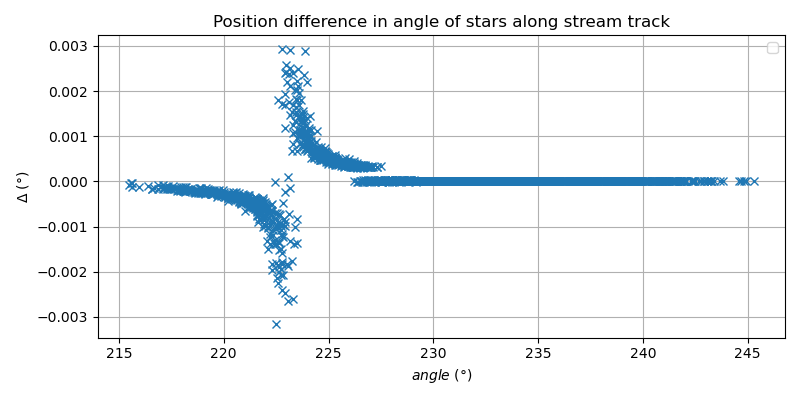

In [400]:
### Plot difference between perturbed and non perturbed vs non-perturbed

plt.figure(figsize=(8, 4))
plt.plot(ra_s, ra_ps-ra_s, 'x')
plt.xlabel(r'$angle $ (°)')
plt.ylabel(r'$\Delta$ (°)')
plt.title(r'Position difference in angle of stars along stream track')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

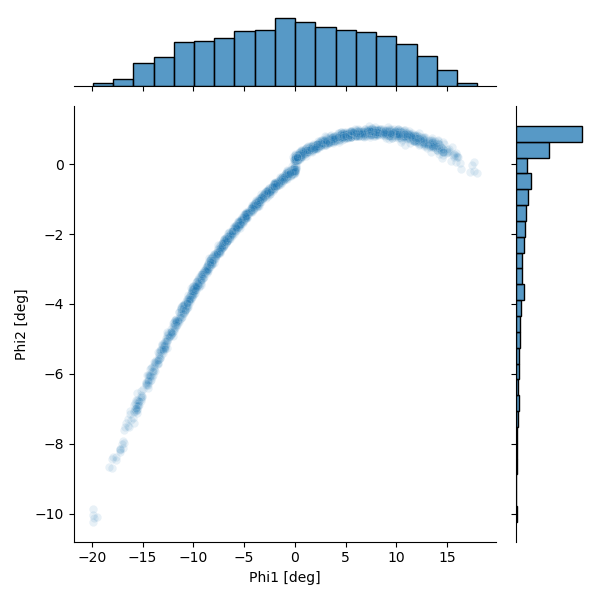

In [401]:
### plot the track in the radec frame to see how it would appears in the stream frame
# plt.figure()
# plt.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
# plt.scatter(phi12_s_trail.phi1, phi12_s_trail.phi2, s=0.5)
# plt.scatter(ra_prog, dec_prog, s=10)
# plt.xlabel("ra [deg]")
# plt.ylabel("dec [deg]")
# plt.title("Perturbed Stellar Stream")
# plt.show()

sns.jointplot(x=phi1_s, y=phi2_s, alpha=0.1)
# ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
plt.xlabel("Phi1 [deg]")
plt.ylabel("Phi2 [deg]")

plt.tight_layout()



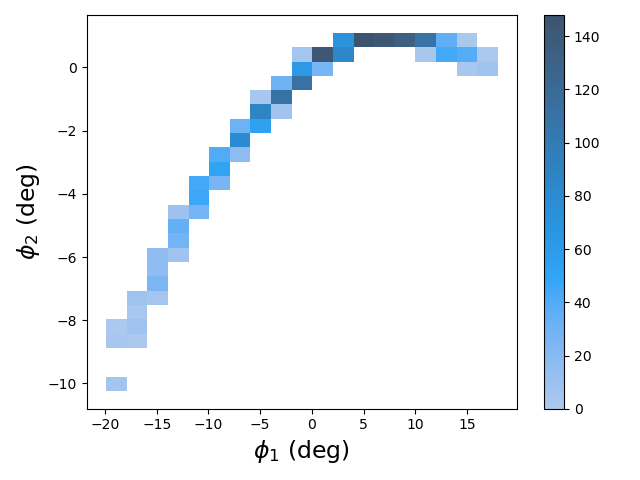

In [404]:
plt.figure()
hist2D = sns.histplot(x=phi1_s,y=phi2_s,cbar=True)
plt.xlabel(r'$\phi_1$ (deg)',fontsize=17)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=17)
plt.tight_layout()


**Step 4: magnitude sampling**

Optional. Gives gri magnitude to stars, depending on isochrone properties and distance modulus. Same class as from stream_sim magnitude sampler



In [ ]:
#Save generated data in the format (Phi1, Phi2)

import numpy as np
import astropy.coordinates as coord
import astropy.units as u
import warnings
from ugali.isochrone import factory

class IsochroneModel:
    """ Isochrone model for assigning magnitudes to stars. """
    
    def __init__(self, config):
        self.config = config
        self.create_isochrone(config)
    
    def create_isochrone(self, config):
        """Create the isochrone model from the configuration."""
        self.iso = factory(**config)
        self.iso.params['distance_modulus'].set_bounds([0, 50])

        if 'distance_modulus' in config:
            warnings.warn('Use the "distance_modulus" section of the config file instead.')
        self.iso.distance_modulus = 0  # Default value
        
    def _dist_to_modulus(self, distance):
        """Convert physical distances (kpc) into distance modulus."""
        if distance is None:
            return 0
        elif np.all(distance == 0):
            warnings.warn("Distances are 0; setting distance modulus to 0.")
            return 0
        else:
            return 5 * np.log10(distance * 1000) - 5  # Convert kpc to pc

    def sample_magnitudes(self, icrs_list):
        """Assign magnitudes (g, r) to stars based on their distance."""
        distances = icrs_list.distance.to(u.kpc).value  # Extract distances in kpc
        distance_moduli = self._dist_to_modulus(distances)  # Compute distance modulus

        # Sample magnitudes for each star
        mag_g, mag_r = self.sample(len(distances), distance_moduli)

        return mag_g, mag_r

    def sample(self, nstars, distance_modulus):
        """Sample magnitudes using the isochrone."""
        stellar_mass = nstars * self.iso.stellar_mass()

        if np.isscalar(distance_modulus):
            mag_g, mag_r = self.iso.simulate(stellar_mass, distance_modulus=self.iso.distance_modulus)
            mag_g, mag_r = [mag + distance_modulus for mag in (mag_g, mag_r)]
        else:
            mag_g, mag_r = self.iso.simulate(stellar_mass, distance_modulus=self.iso.distance_modulus)
            mag_g, mag_r = [mag + distance_modulus for mag in (mag_g, mag_r)]

        return mag_g, mag_r

config = {
    "name": "Bressan2012",
    "survey": "lsst",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}

isochrone_model = IsochroneModel(config)

# Example: Assign magnitudes to each star in list
mag_g_ps, mag_r_ps = isochrone_model.sample_magnitudes(icrs_ps)
mag_g_s_trail, mag_r_s_trail = isochrone_model.sample_magnitudes(icrs_s_trail)
mag_g_s_lead, mag_r_s_lead = isochrone_model.sample_magnitudes(icrs_s_lead)

# in PHI12
# mag_g_phi12, mag_r_phi12 = isochrone_model.sample_magnitudes(stream_phi12)

# print("First 5 stars (g, r) in icrs_ps:")
# for i in range(5):
#     print(f"Star {i+1}: g = {mag_g_ps[i]:.2f}, r = {mag_r_ps[i]:.2f}")


In [ ]:
from astropy.table import Table

# Define the directory path
data_dir = "../data/"  # Relative path from "notebooks/"
os.makedirs(data_dir, exist_ok=True)  # Create directory if it doesn't exist

def save_star_data(star_list, mag_g, mag_r, coord_system, filename):
    """Save RA, Dec, Distance, mag_g, mag_r to a CSV file in 'data/' directory."""
    
    # Create Astropy table
    if coord_system == 'radec':
        table = Table(
            data=[
                star_list.ra.deg,         # RA in degrees
                star_list.dec.deg,        # Dec in degrees
                star_list.distance.kpc,   # Distance in kpc
                mag_g,                    # g-band magnitude
                mag_r                     # r-band magnitude
            ],
            names=["ra", "dec", "dist", "mag_g", "mag_r"]
        )
    elif coord_system == 'phi12':
        table = Table(
            data=[
                star_list.Phi1.deg,       # Phi1 in degrees
                star_list.Phi2.deg,       # Phi2 in degrees
                star_list.distance.kpc,   # Distance in kpc
                mag_g,                    # g-band magnitude
                mag_r                     # r-band magnitude
            ],
            names=["phi1", "phi2", "dist", "mag_g", "mag_r"]
        )
    else:
        print('error, use phi12 or radec')

    # Save to CSV
    filepath = os.path.join(data_dir, filename)
    table.write(filepath, format="csv", overwrite=True)
    print(f"Saved: {filepath}")

# Save s_trail separately
#save_star_data(icrs_s_trail, mag_g_s_trail, mag_r_s_trail, "icrs_s_trail.csv")

# Concatenate trail and lead into one table
from astropy.coordinates import concatenate

#from radec 
Pal5 = concatenate([icrs_s_lead, icrs_s_trail])
mag_g_combined = np.concatenate([mag_g_s_lead, mag_g_s_trail])
mag_r_combined = np.concatenate([mag_r_s_lead, mag_r_s_trail])
# save_star_data(Pal5, mag_g_combined, mag_r_combined, 'radec', f"{cluster}_stars.csv")

#from phi12
# save_star_data(stream_phi12, mag_g_combined, mag_r_combined, 'phi12', f"{cluster}_stars.csv")

In [ ]:
from astropy.table import Table

# Load the data
data_file = f"../data/{cluster}_stars.csv"  # Path to the saved CSV
table = Table.read(data_file, format="csv")

# Compute the color index (g-r)
color_index = table["mag_g"] - table["mag_r"]

# H-R diagram (Absolute mag vs. Color index)
plt.figure(figsize=(8, 6))
plt.scatter(color_index, table["mag_g"], s=5, c=table["dist"], cmap="plasma", alpha=0.7)

# Flip the y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels
plt.xlabel(r"Color Index $(g - r)$")
plt.ylabel(r"Apparent Magnitude $g$")
plt.title(f"H-R Diagram (Pal5, t = {t_disrupt})")

# Colorbar
plt.colorbar(label="distance modulus")

# Show the plot
plt.show()


# Stellar stream Density

Now that we got star distribution along the stream, we are interested in computing the density along the track. To do so we define a function that count the number of star in a given box. The density is defined as follow: Phi1 increase linearly in the range [Phimin,Phimax]. To each interval [Phi1-deltaPhi1,Phi1+deltaPhi1] is assigned a mid track width value Phi2. It is sum the number of stars in the column of witdh w corresponding to Phi1[i], where w is the sum of each bin size in the Phi2 direction, i.e. the width of the track.

First part is for stream_search

In [ ]:
#ensure to have a stream in the shape [[star1], [star2], ...] to agree with real star data.
stream_phi12 = np.array([sts_phi1.degree, sts_phi2.degree]).T
stream_phi12
#to do: convert with pd data frame [Phi1, Phi2, pmPhi1, pmPhi2, magr,...]

In [ ]:
from astropy.table import Table
import numpy as np
from scipy.optimize import least_squares

def gaussian(params, x):
    A, mu, sigma = params
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def residuals(params, x, y):
    return gaussian(params, x) - y

def stream_density(stream, delta_phi1=0.02, max_fev=5000):
    phi1_stars = stream.T[0]
    phi2_stars = stream.T[1]

    phi1_min = np.min(phi1_stars) + delta_phi1
    phi1_max = np.max(phi1_stars) - delta_phi1
    phi2_min = np.min(phi2_stars)
    phi2_max = np.max(phi2_stars)
    nbins1 = int((phi1_max - phi1_min) / delta_phi1)

    phi1_vals, phi2_vals, nstars_vals, width_vals = [], [], [], []

    for phi1_t in np.arange(phi1_min, phi1_max, delta_phi1):
        width = 0.2
        mask_phi1 = (np.abs(phi1_stars - phi1_t) < width)
        selected_phi2 = phi2_stars[mask_phi1]

        if len(selected_phi2) > 0:
            hist_nstars, bin_phi2 = np.histogram(selected_phi2, bins=1000, range=(phi2_min, phi2_max))
            max_bin_idx = np.argmax(hist_nstars)
            max_phi2 = (bin_phi2[max_bin_idx] + bin_phi2[max_bin_idx + 1]) / 2

            # Initial guess
            A0 = max(hist_nstars)
            mu0 = max_phi2
            sigma0 = 1.0
            p0 = [A0, mu0, sigma0]

            # Fit using least_squares
            result = least_squares(
                residuals, p0, args=(bin_phi2[:-1], hist_nstars),
                max_nfev=max_fev
            )

            if result.success and result.nfev < max_fev and result.x[0]<100:
                A_fit, mu_fit, sigma_fit = result.x
                phi1_vals.append(phi1_t)
                phi2_vals.append(mu_fit)
                nstars_vals.append(A_fit)
                width_vals.append(sigma_fit)
            else:
                # You can log or skip silently
                continue

    density_table = Table([phi1_vals, phi2_vals, nstars_vals, width_vals],
                          names=('phi1', 'phi2', 'nstars', 'width'))
    return density_table

stream_erkal = stream_density(stream_phi12, delta_phi1=0.1)


In [ ]:
# Plot the density in the frame (scatter plot of phi1, phi2 values)
plt.figure(figsize=(10, 6))
plt.hist2d(stream_phi12.T[0], stream_phi12.T[1], bins=[1000, 1000], cmap='plasma')
plt.scatter(stream_erkal['phi1'], stream_erkal['phi2'], c=stream_erkal['nstars'], cmap='gist_yarg', s=5)
plt.colorbar(label='Number of Stars')
plt.xlabel('phi1 (degrees)')
plt.ylabel('phi2 (degrees)')
plt.title('Star Density Along the Stream')
# plt.grid(True)
plt.show()

In [ ]:
###Just cheking if the gaussian fit works
i = 123  # index in stream_erkal
from scipy.integrate import trapezoid
# Center Phi1 value and width of the bin
phi1_center = stream_erkal['phi1'][i]
phi1_width = 0.2

# Select stars in that Phi1 slice
mask = np.abs(stream_phi12.T[0] - phi1_center) < phi1_width
phi2_slice = stream_phi12.T[1][mask]

# Make histogram
phi2_min, phi2_max = np.min(phi2_slice), np.max(phi2_slice)
hist, bins = np.histogram(phi2_slice, bins=10, range=(phi2_min, phi2_max))
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Get fitted parameters
A_fit = stream_erkal['nstars'][i]
mu_fit = stream_erkal['phi2'][i]
sigma_fit = stream_erkal['width'][i]

# Gaussian for comparison
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

phi2_fine = np.linspace(phi2_min, phi2_max, 500)
gauss_fit = gaussian(phi2_fine, A_fit, mu_fit, sigma_fit)
print(np.max(gauss_fit/trapezoid(gauss_fit,phi2_fine)))
# Plot
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist/trapezoid(hist,bin_centers), width=(bins[1] - bins[0]), alpha=0.5, label="Histogram")
plt.plot(phi2_fine, gauss_fit/trapezoid(gauss_fit,phi2_fine), 'r-', linewidth=2, label="Fitted Gaussian")
plt.axvline(mu_fit, color='k', linestyle='--', label="Gaussian Mean")
plt.title(f'Phi1 = {phi1_center:.2f} Slice')
plt.xlabel("Phi2")
plt.ylabel("Star Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### Save data file to csv
# sys.path.append(os.path.abspath('../'))
# base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))


stream_erkal.write(f'{base_dir}/data/hall_2024_{cluster}_input.csv', format='csv', overwrite=True)

Second part is for true observed surfacic stellar density

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

def compute_stream_density(data, bin_width=0.1, plot=True):
    """
    Calcule la densité linéique projetée le long de Phi1.
    
    Parameters:
    - data (Astropy Table ou ndarray): avec colonnes ['Phi1', 'Phi2', 'dist'] ou équivalent
    - bin_width (float): largeur des bins en degrés
    - plot (bool): si True, trace le profil de densité

    Returns:
    - bin_centers (ndarray): centres des bins
    - densities (ndarray): densité surfacique (étoiles / degré)
    """
    
    # Adapter selon le type d'entrée
    if isinstance(data, Table):
        if "Phi1" in data.colnames:
            phi1 = np.array(data["Phi1"])
        else:
            raise ValueError("La table ne contient pas de colonne 'Phi1'.")
    elif isinstance(data, np.ndarray):
        if data.shape[1] >= 1:
            phi1 = data[:, 0]  # on suppose Phi1 en première colonne
        else:
            raise ValueError("Le tableau numpy n'a pas assez de colonnes (attendu: >=1).")
    else:
        raise TypeError("Entrée non supportée : utiliser Astropy Table ou numpy ndarray.")
    
    # Construction des bins
    phi1_min, phi1_max = np.min(phi1), np.max(phi1)
    bins = np.arange(phi1_min, phi1_max + bin_width, bin_width)
    
    # Histogramme
    counts, edges = np.histogram(phi1, bins=bins)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    densities = counts / bin_width  # densité surfacique (étoiles / degré)
    densities /= np.mean(densities)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(bin_centers, densities, drawstyle='steps-mid')
        plt.xlabel("Phi1 (deg)")
        plt.ylabel("Densité (étoiles / deg)")
        plt.title("Densité le long du courant stellaire")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return bin_centers, densities


In [ ]:
def fit_polynomial_density(phi1_centers, densities_norm, degree=3, plot=True):
    """
    Adjust a polynom to a histogram
    params out: coeffs, poly_func
    """
    from numpy.polynomial.polynomial import Polynomial
    coeffs = Polynomial.fit(phi1_centers, densities_norm, degree).convert().coef
    poly_func = Polynomial(coeffs)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(phi1_centers, densities_norm, label="Normalized density per bin", drawstyle='steps-mid')
        plt.plot(phi1_centers, poly_func(phi1_centers), label=f"polymonial {degree}", color='red')
        plt.xlabel(r'$\phi_1$ (°)')
        plt.ylabel("Normalized density")
        plt.title("Perturbed stellar density along stream track")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return coeffs, poly_func

In [ ]:
#Compute normalized density
centers, dens_norm_unperturbed = compute_stream_density(stream_phi12_lead, bin_width=0.1, plot=False)
centers, dens_norm_perturbed = compute_stream_density(stream_phi12_perturbed, bin_width=0.1, plot=False)

#adjust polynom
coeffs_unperturbed, poly_model_unperturbed = fit_polynomial_density(centers, dens_norm_unperturbed, degree=6)
coeffs_perturbed, poly_model_perturbed = fit_polynomial_density(centers, dens_norm_perturbed, degree=6)


In [ ]:
plt.figure(figsize=(8, 4))
# plt.plot(centers, (dens_norm_perturbed-dens_norm_unperturbed)/dens_norm_unperturbed, drawstyle='steps-mid')
plt.plot(centers, (poly_model_perturbed(centers)-poly_model_unperturbed(centers))/poly_model_unperturbed(centers), color='red')
plt.xlabel(r'$\phi_1$ (°)')
plt.ylabel(r'$\delta(\phi_1)$')
plt.title("Relative stellar density difference along stream track")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
